# Settyl Data Science And Machine Learning Engineer Task

## Import necessary modules and utility functions

In [1]:
import json
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR
from sklearn.metrics import accuracy_score, precision_score, recall_score

from utils import preprocess, train_test_split, tokenize, labels2tensor, dynamically_batch, Model

torch.random.manual_seed(0)
np.random.seed(0)

## Importing and visualizing the dataset

We laod the data from the json path below. Data is in the form of a list of dictionaries, each containing pair of values of external status and internal status. To visualize the data, we print the tail of the dataset (last 5 rows). We use the last 5 rows instead of the first 5 to check for any redundant rows that may have been loaded due to newlines at the end of the data file.

In [2]:
# Path to json
json_path = "dataset.json"

# Loading and shuffling the data
with open(json_path) as fp:
    data = np.random.permutation(json.load(fp))

# Tail of the data
data[-5:]

array([{'externalStatus': 'DEPARTCU', 'internalStatus': 'Departure'},
       {'externalStatus': 'DEPARTCU', 'internalStatus': 'Departure'},
       {'externalStatus': 'Import Unloaded from Rail', 'internalStatus': 'Unloaded on Vessel'},
       {'externalStatus': 'Gate out', 'internalStatus': 'Gate Out'},
       {'externalStatus': 'Discharge', 'internalStatus': 'Departure'}],
      dtype=object)

## Preprocessing

To preprocess the data, we iterate over the pairs of external and internal statuses. We then strip off any white spaces and convert the texts to lower case. We also remove any non-alphanumeric characters for simplicity. Check the `preprocess` function in [utils.py](utils.py) for more details.

We extract the inputs (external statuses), labels (internal statuses), unique labels, and vocabulary after preprocessing. Note that the vocabulary only contains distinct words from external statuses since internal statuses are treated as classes.

In [3]:
texts, labels, unique_labels, vocab = preprocess(data)

In [4]:
# Length of our vocabulary

len(vocab)

124

In [5]:
# Unique labels in our dataset

unique_labels

['arrival',
 'departure',
 'empty container released',
 'empty return',
 'gate in',
 'gate out',
 'inbound terminal',
 'intransit',
 'loaded on vessel',
 'off rail',
 'on rail',
 'outbound terminal',
 'port in',
 'port out',
 'unloaded on vessel']

In [6]:
# Maximum number of words in our texts

max(map(lambda x: len(x.split()), texts))

12

### Splitting the data

We split the data into train and test sets. Since we have a very small dataset, we will use the test set for both validation (for hyperparameter tuning) and testing (model evaluation).

In [7]:
train_ratio = 0.95
shuffle = True

train_texts, train_labels, test_texts, test_labels = train_test_split(texts, labels, train_ratio, shuffle)

In [8]:
# Lengths of train and test sets

len(train_texts), len(test_texts)

(1160, 62)

### Creating tensor dataset

The train data is dynamically batched (batching similar length sequences together) and the labels are vectorized. We dynamically batch our train set for efficient computations, since padding will be minimal. The test set in vectorized into one single batch.

In [9]:
max_tokens = 15

test_inputs, test_classes = tokenize(test_texts, vocab, max_tokens), labels2tensor(test_labels, unique_labels)

In [10]:
# Tail of vectorized test set

test_inputs[-5:], test_classes[-5:]

(tensor([[48, 83, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [48, 83, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [48, 83, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [48, 83, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [48, 83, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([5, 5, 8, 1, 8]))

Now, we will implement dynamic batching for train set. To do so, we sort the train texts by the number of tokens and batch accordingly. Refer [utils.py](utils.py) for more details.

In [11]:
batch_size = 32

batched_train = dynamically_batch(train_texts, train_labels, batch_size, vocab, unique_labels, max_tokens)

In [12]:
# Last element of the dynamically batched train set

batched_train[-1]

(tensor([[116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4],
         [116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4],
         [116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4],
         [116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4],
         [116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4],
         [116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4],
         [116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4],
         [116,  44,  67,  81,   4,  10,  92,  78,  31,  67,  81,   4]]),
 tensor([14,  8,  8, 14,  8, 14,  8,  8]))

## Defining the model, optimizer, and scheduler

We define a sequence classification model with labels as unique internal statuses. Check the model implementation in [utils.py](utils.py) for more information about model architecture.

In [13]:
embedding_dim = 10
hidden_size = 8
lstm_layers = 4
lrelu_slope = 0.2
dropout = 0.3

model = Model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_classes=len(unique_labels),
    hidden_size=hidden_size,
    lstm_layers=lstm_layers,
    lrelu_slope=lrelu_slope,
    dropout=dropout
)

In [14]:
# Model info

model

Model(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(124, 10)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (lstm): LSTM(10, 8, num_layers=4, dropout=0.3)
  (dense): Linear(in_features=8, out_features=15, bias=True)
  (loss): CrossEntropyLoss()
)

Now, we define the optimizer and scheduler we will use to train out model. We use the Adam optimizer and a linear learning rate schedule.

In [15]:
initial_lr = 8e-2       # Initial learning rate of the optimizer
start_factor = 1        # Starting factor multiplied to the learning rate
end_factor = 0.2        # End factor multiplied to the learning rate
iters = 20              # Total number of epochs over which start_factor linearly grows towards end_factor

optimizer = Adam(model.parameters(), lr=initial_lr)
scheduler = LinearLR(optimizer, start_factor=start_factor, end_factor=end_factor, total_iters=iters)

## Training the model

Now we finally train our model. We track the average training loss, test loss, and learning rate values to tune the model hyperparameters.

In [16]:
num_epochs = 50
num_batches = len(batched_train)

train_loss, test_loss, lr_vals = [], [], []
test_accuracy, test_precision, test_recall = [], [], []

for epoch in range(num_epochs):
    
    # Tracks total epoch loss
    epoch_loss = 0

    for batch, (inp, label) in enumerate(batched_train):

        loss = model(x=inp, labels=label, training=True)["loss"]
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"\rEpoch: {epoch+1}/{num_epochs} Batch: {batch+1}/{num_batches}", end="\t\t")
    
    # Track learning rate value
    lr_vals.append(scheduler.get_last_lr())
    scheduler.step()

    # Track average epoch loss
    train_loss.append(epoch_loss / num_batches)

    # Test model
    with torch.no_grad():
        test_output = model(test_inputs, test_classes, False)
    test_loss.append(test_output["loss"].item())
    test_accuracy.append(accuracy_score(test_classes, test_output["predictions"]))
    test_precision.append(precision_score(test_classes, test_output["predictions"], average="micro"))
    test_recall.append(recall_score(test_classes, test_output["predictions"], average="micro"))

Epoch: 50/50 Batch: 37/37		

## Metrics analysis

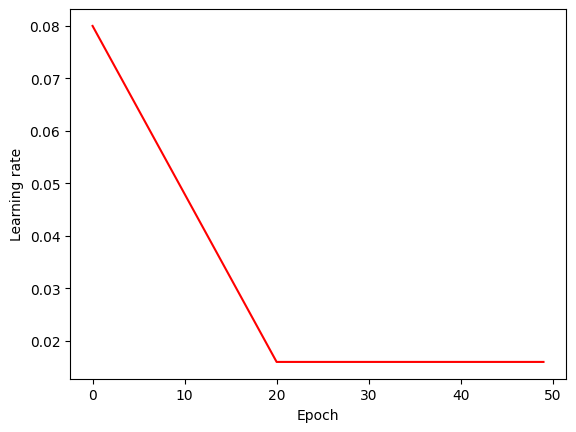

In [17]:
# Plotting learning rate schedule

plt.plot(lr_vals, color="red")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.show()

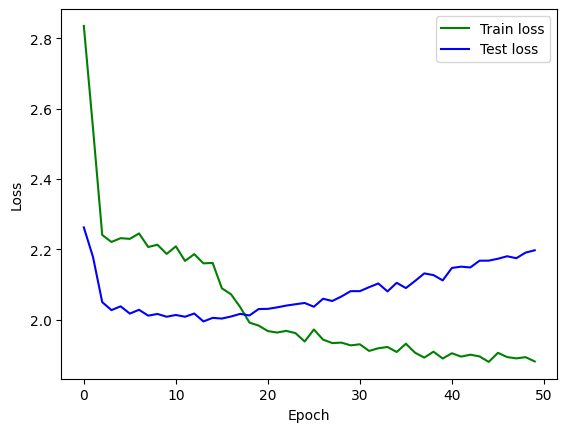

In [18]:
# Plotting train and test loss

plt.plot(train_loss, label="Train loss", color="green")
plt.plot(test_loss, label="Test loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

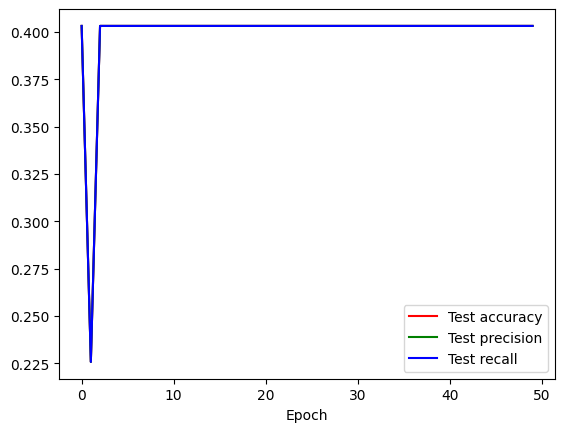

In [19]:
# Plotting test accuracy, precision, recall

plt.plot(test_accuracy, label="Test accuracy", color="red")
plt.plot(test_precision, label="Test precision", color="green")
plt.plot(test_recall, label="Test recall", color="blue")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Save the model

After tuning the hyperparameters and getting an optimal model, we will save the model's state dictionary for later use. Note that we save the state dictionary rather than the whole model for memory efficiency.

In [20]:
model_path = "model.pth"

torch.save(model.state_dict(), model_path)